#  信用评分卡模型案例

## 业务理解

### 建模目的
基于客户数据，通过预测客户未来两年是否会陷入财务危机的概率来改善银行信用评分的质量。
### 业务背景
a、信用评分是指根据银行客户的各种历史信用资料，利用一定的信用评分模型，得到不同等级的信用分数，根据客户的信用分数，授信者可以通过分析客户按时还款的可能性，据此决定是否给予授信以及授信的额度和利率。虽然授信者通过人工分析客户的历史信用资料，同样可以得到这样的分析结果，但利用信用评分却更加快速、更加客观、更具有一致性。

b、信用评分模型可用“四张卡”来表示，分别是 A卡（Application score card，申请评分卡）、B卡（Behavior score card，行为评分卡）、C卡（Collection score card，催收评分卡）和 F卡（Anti-Fraud Card，反欺诈评分卡），分别应用于贷前、贷中、贷后。

c、本次要建立的信用评分卡属于信用评分卡中的A卡（Application score card）即申请评分卡，是客户贷款前对客户实行打分制，以期对客户有一个优质与否的评判。

### 信用评分卡建模流程

信用风险评级模型的主要开发流程如下： 

1）数据读取：训练集数据、测试集数据

2）探索性分析EDA：变量分布情况-中位数、均值等

3）数据预处理：缺失值处理、异常值处理、特征相关性分析

4）特征选择：变量离散化、WOE变换

5）模型开发：逻辑回归

6）模型评估：K-S指标、拟合度曲线

7）信用评分：好坏比、基础分值等创立标准评分卡

8）对测试集进行预测和转化为信用评分卡

## 数据理解

### 数据来源
本次建模数据来自Kaggle竞赛网的Give Me Some Credit数据集，该数据集收集了15万条个体客户的基本信息，其中12万条训练集数据，3万条测试集数据。数据集中的包含10个字段，其中一个为目标字段，下表展示了各个字段的含义。
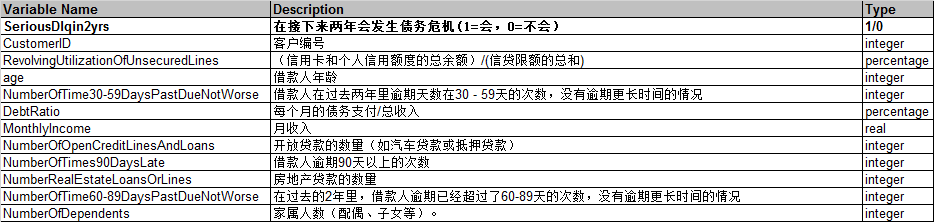

### 字段理解
根据业务的背景，可以上客户信息分为以下几类：

基本信息：age，借款人当时的年龄
负债信息:RevolvingUtilizationOfUnsecuredLines-信用贷款比例、DebtRatio-负债比率、NumberOfOpenCreditLinesAndLoans-开放贷款数量、NumberRealEstateLoansOrLines-房地产贷款数量
偿还能力：MonthlyIncome-月收入
历史信用记录：NumberOfTime30-59DaysPastDueNotWorse、NumberOfTime60-89DaysPastDueNotWorse、NumberOfTimes90DaysLate（两年内35-59天逾期次数、两年内60-89天逾期次数、两年内90天或高于90天逾期的次数）
人际社交信息：NumberOfDependents-借款人的家属数量（不包括本人在内）
目标变量：SeriousDlqin2yrs,在接下来两年发生债务危机（1-会，0-不会）
时间窗口：自变量的观察窗口为过去两年，因变量表现窗口为未来两年

## 数据预处理

### 读取数据

In [89]:
#导入包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

#导入统计学常用数据包
from scipy import stats
from scipy.stats import norm, skew 

In [90]:
#导入测试集与训练集
train_data = pd.read_csv('cs-training.csv')
test_data = pd.read_csv('cs-test v2.csv')

In [91]:
#查看数据维度和信息
#训练集
print(train_data.shape)
print('-------------------')
print(train_data.info())
print('-------------------')
#测试集
print(test_data.shape)
print('-------------------')
print(test_data.info())

(120000, 12)
-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 12 columns):
CustomerID                              120000 non-null int64
RevolvingUtilizationOfUnsecuredLines    120000 non-null float64
age                                     120000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    120000 non-null int64
DebtRatio                               120000 non-null float64
MonthlyIncome                           96224 non-null float64
NumberOfOpenCreditLinesAndLoans         120000 non-null int64
NumberOfTimes90DaysLate                 120000 non-null int64
NumberRealEstateLoansOrLines            120000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    120000 non-null int64
NumberOfDependents                      116860 non-null float64
SeriousDlqin2yrs                        120000 non-null int64
dtypes: float64(4), int64(8)
memory usage: 11.0 MB
None
-------------------
(30000, 12)
-----------------

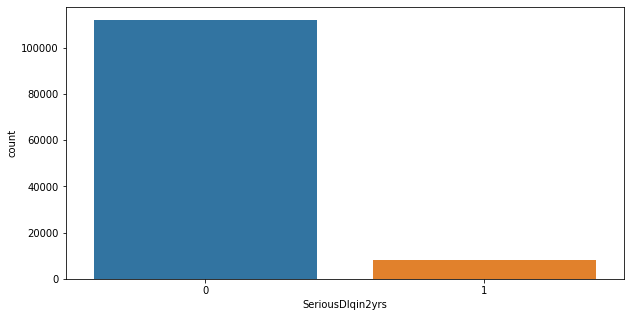

训练集数据中，好客户数量为：112018,坏客户数量为：7982,坏客户所占比例为：6.65%


In [92]:
#查看好坏客户分布
#创建子图及间隔设置
f,ax = plt.subplots(figsize=(10,5))
sns.countplot('SeriousDlqin2yrs',data=train_data)
plt.show()

badnum=train_data['SeriousDlqin2yrs'].sum()
goodnum=train_data['SeriousDlqin2yrs'].count()-train_data['SeriousDlqin2yrs'].sum()
print('训练集数据中，好客户数量为：%i,坏客户数量为：%i,坏客户所占比例为：%.2f%%' %(goodnum,badnum,(badnum/train_data['SeriousDlqin2yrs'].count())*100))
#样本标签及其不平衡，后面需要使用balance参数

###  重复值处理
训练集数据高达12万条，很大概率含有重复值，先将重复值去除。

In [5]:
#检查数据
print("处理前数据大小 : {} ".format(train_data.shape))

处理前数据大小 : (120000, 12) 


In [6]:
#按全部列统计重复值
train_data.duplicated().sum()

0

In [7]:
#按具体列统计重复值
train_data.duplicated(subset=['CustomerID']).sum()

0

In [8]:
#获取去重复的字段名列表
cols_df = train_data.columns.values.tolist()
cols_df

['CustomerID',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents',
 'SeriousDlqin2yrs']

In [9]:
#去除训练数据中的重复值
train_data.drop_duplicates(subset = cols_df, inplace=True)

#检查数据
print("处理后数据大小 : {} ".format(train_data.shape))

处理后数据大小 : (120000, 12) 


### 缺失值处理

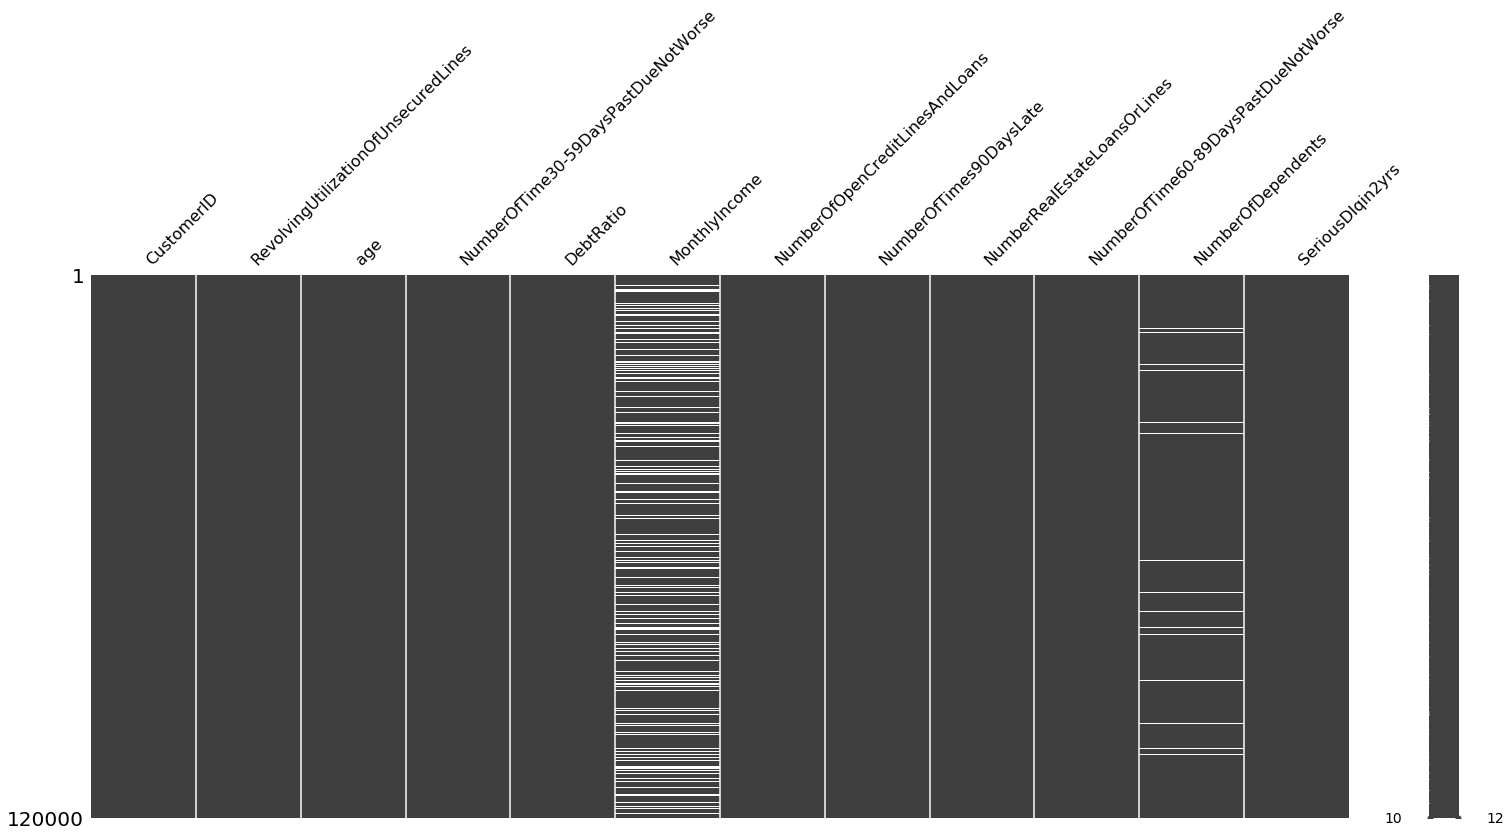

In [10]:
#缺失值查看
import missingno as msno
msno.matrix(train_data)

In [11]:
train_data.isnull().mean()

CustomerID                              0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198133
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026167
SeriousDlqin2yrs                        0.000000
dtype: float64

In [12]:
##NumberOfDependents存在缺失值,缺失率为0.026，因此直接删除缺失值。
#检查数据
print("处理前数据集大小 : {} ".format(train_data.shape))

train_data.dropna(subset=['NumberOfDependents'],inplace=True)

#检查数据
print('--------------------------------')
print("处理后数据集大小 : {} ".format(train_data.shape))

处理前数据集大小 : (120000, 12) 
--------------------------------
处理后数据集大小 : (116860, 12) 


In [13]:
#Monthlyincome，缺失率为0.198，缺失的数据较多，不能直接删除含有缺失值的记录，所以我们根据变量之间的相关关系填补缺失值，我们采用随机森林法：

# 用随机森林对缺失值预测填充函数
from sklearn.ensemble import RandomForestRegressor
def set_missing(df):
    # 把已有的数值型特征取出来
    process_df = df.ix[:,[5,0,1,2,3,4,6,7,8,9]]  #5-月收入，0-ID，1-9:其它数值字段
    # 分成已知该特征和未知该特征两部分
    known = process_df[process_df.MonthlyIncome.notnull()].as_matrix() #已知值
    unknown = process_df[process_df.MonthlyIncome.isnull()].as_matrix() #缺失值
    # X为特征属性值
    X = known[:, 1:]  #所有行，第1列之后所有列
    # y为结果标签值
    y = known[:, 0]  #所有行，第1列，即月收入那一列
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=200,max_depth=3,n_jobs=-1)
    rfr.fit(X,y)
    # 用得到的模型进行未知特征值预测
    predicted = rfr.predict(unknown[:, 1:]).round(0)  #传入缺失值的x
    print(predicted)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.MonthlyIncome.isnull()), 'MonthlyIncome'] = predicted 
    #loc是按行名索引，这里是一个筛选操作，选取MonthlyIncome列中为空的位置替换为predicted中的值
    return df

In [14]:
set_missing(train_data)

[8439. 8439. 1801. ... 1109. 1801. 1109.]


,CustomerID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,2,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,3,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,4,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,5,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0
5,6,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,0
6,7,0.305682,57,0,5710.000000,8439.0,8,0,3,0,0.0,0
7,8,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0,0
9,10,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0,0
10,11,0.644226,30,0,0.309476,2500.0,5,0,0,0,0.0,0


### 异常值处理

In [15]:
# 本次单变量探索用到的自定义函数
##分位法处理异常值
def IQR_Cleaner(df,atrribute_name,floor,ceiling,method):
    ##df：要清洗的DataFrame，DataFrame
    ##atrribute_name：清洗的属性名称，字符串
    ##floor：清洗的下分位数，float
    ##ceiling：清洗的上分位数，float
    ##method:'drop' 即去除异常值，或者 ‘fill’即用上下临界值来替代异常值
    Q1 = df[atrribute_name].quantile(floor)
    Q3 = df[atrribute_name].quantile(ceiling)
    IQR = Q3 - Q1
    down = Q1 - 1.5*IQR
    up = Q3 + 1.5*IQR
    if method == 'drop':
        df = df.loc[(df[atrribute_name]<up) & (df[atrribute_name]>down),:]
    else:
        df.loc[df[atrribute_name]>up,atrribute_name]=up   #大于up的值替换为up
        df.loc[df[atrribute_name]<down,atrribute_name]=down  #小于down的值替换为down
    return df

##单变量分布可视化函数
def Distribution_worker(target,bins):
    ## target 需要探索的单变量
    ## 直方图
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(target, fit=norm, bins=bins)
    (mu, sigma) = norm.fit(target)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
    plt.ylabel('Frequency')
    plt.title('distribution')
    
    ##箱线图
    plt.subplot(122)
    sns.boxplot(y =target , width=0.2)

#### age字段---连续变量


 mu = 52.07 and sigma = 14.59



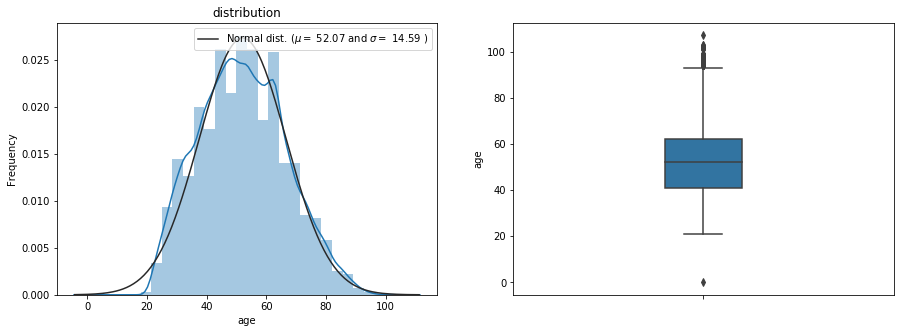

In [16]:
#输入目标变量
target = train_data.age

#变量分布特征
Distribution_worker(target,30)

1）从直方图来看age字段分布几乎没有偏斜。
2）从箱线图来看age字段有部分异常值，我们用天花板法处理这些异常值，将超出1.5倍IQR距离的数值赋值为领临界值。


 mu = 52.06 and sigma = 14.58



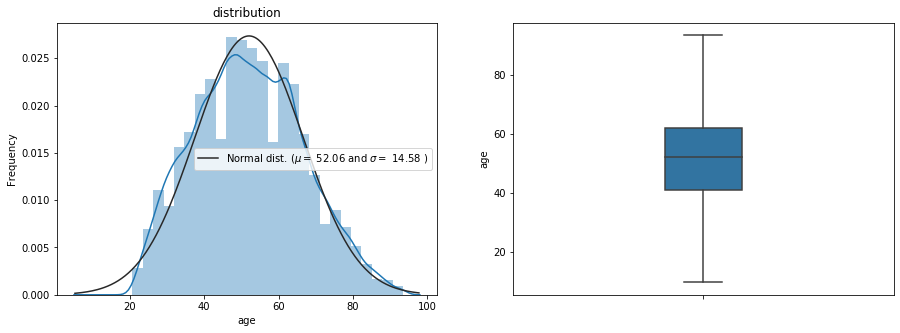

In [17]:
#异常值处理
train_data = IQR_Cleaner(train_data, 'age', 0.25, 0.75, 'fill')

#输入目标变量
target = train_data.age

#处理后变量分布特征
Distribution_worker(target,30)

In [18]:
train_data.age.describe()

count    116860.000000
mean         52.063161
std          14.579245
min           9.500000
25%          41.000000
50%          52.000000
75%          62.000000
max          93.500000
Name: age, dtype: float64

age是连续型变量

#### RevolvingUtilizationOfUnsecuredLines 字段---信用贷款比例---连续变量


 mu = 5.74 and sigma = 249.39



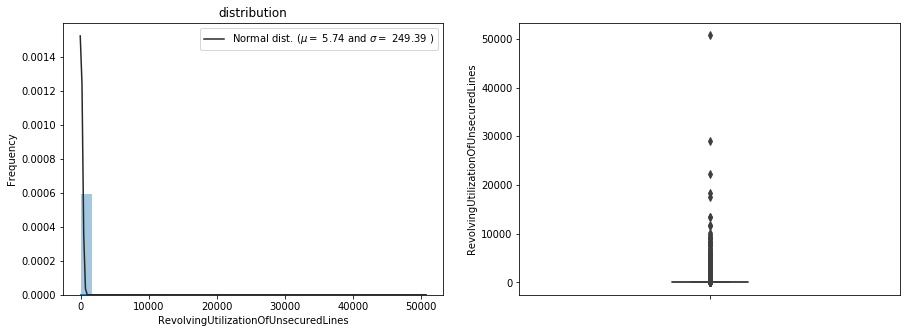

In [19]:
#输入目标变量
target = train_data.RevolvingUtilizationOfUnsecuredLines

#变量分布特征
Distribution_worker(target,30)

 RevolvingUtilizationOfUnsecuredLines字段大于1的记录占比: 0.021908735899387057 

 mu = 0.31 and sigma = 0.34



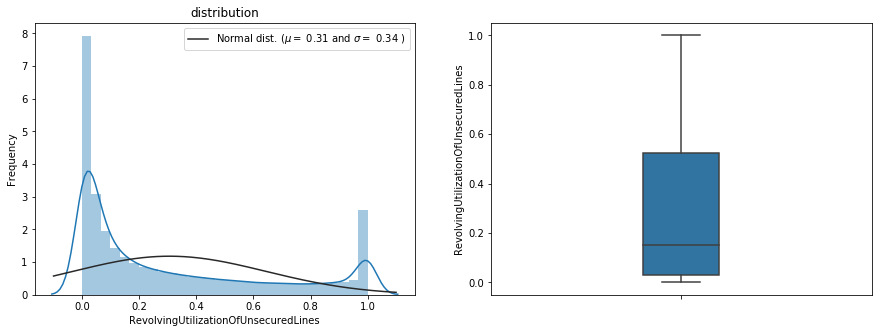

In [20]:
#异常值处理
#根据业务逻辑，信用贷款比例大于1的为异常值
outlier_num  = train_data.loc[train_data.RevolvingUtilizationOfUnsecuredLines>1].shape[0]  #计算大于1的数量
print(" RevolvingUtilizationOfUnsecuredLines字段大于1的记录占比: {} ".format(outlier_num/119587))  #计算大于1的比例
#异常值占比2.7%，占比较少，可以剔除异常值
train_data = train_data.loc[train_data.RevolvingUtilizationOfUnsecuredLines<=1]  

#处理后字段分布特征

#输入目标变量
target = train_data.RevolvingUtilizationOfUnsecuredLines

#变量分布特征
Distribution_worker(target,30)

In [21]:
train_data.RevolvingUtilizationOfUnsecuredLines.describe()

count    114240.000000
mean          0.306657
std           0.337682
min           0.000000
25%           0.029836
50%           0.150131
75%           0.524836
max           1.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

RevolvingUtilizationOfUnsecuredLines是连续变量

#### DebtRatio 字段---负债比率---连续变量


 mu = 337.19 and sigma = 1907.46



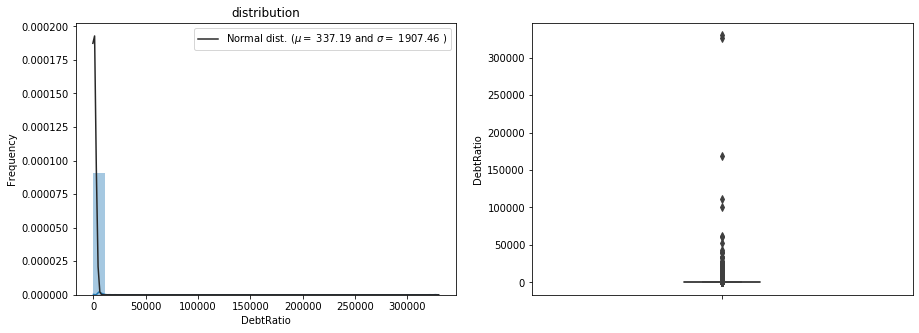

In [22]:
#输入目标变量
target = train_data.DebtRatio

#变量分布特征
Distribution_worker(target,30)

 DebtRatio字段大于1的记录占比: 0.2079490245595257 

 mu = 0.59 and sigma = 0.58



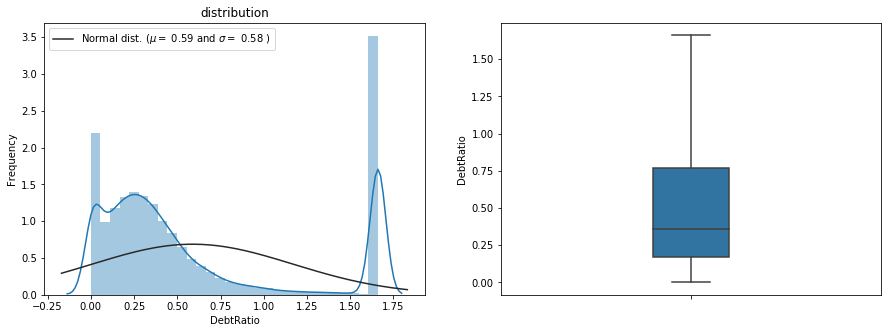

In [23]:
#异常值处理
#根据业务逻辑，负债比率大于1的为异常值
outlier_num  = train_data.loc[train_data.DebtRatio>1].shape[0]   
print(" DebtRatio字段大于1的记录占比: {} ".format(outlier_num/119587)) 

#异常值占比25.5%，占比较大，用天花板法处理异常值
train_data = IQR_Cleaner(train_data, 'DebtRatio', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = train_data.DebtRatio

#变量分布特征
Distribution_worker(target,30)

In [24]:
train_data.DebtRatio.describe()

count    114240.000000
mean          0.588579
std           0.580611
min           0.000000
25%           0.171839
50%           0.357850
75%           0.767396
max           1.660732
Name: DebtRatio, dtype: float64

#### NumberOfOpenCreditLinesAndLoans 字段---开放贷款数量


 mu = 8.58 and sigma = 5.15



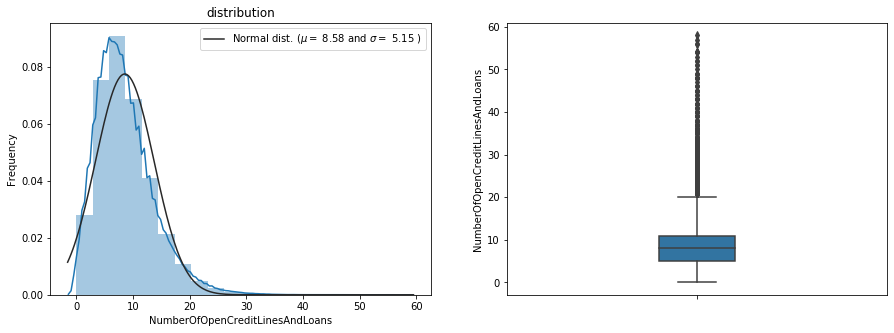

In [25]:
#输入目标变量
target = train_data.NumberOfOpenCreditLinesAndLoans

#变量分布特征
Distribution_worker(target,20)


 mu = 8.45 and sigma = 4.74



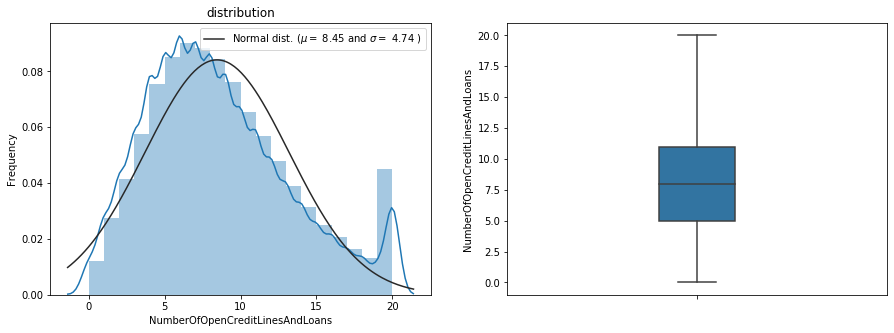

In [26]:
#从箱型图可以看出存在一些大于临界值的异常值，用天花板法处理异常值
train_data = IQR_Cleaner(train_data, 'NumberOfOpenCreditLinesAndLoans', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = train_data.NumberOfOpenCreditLinesAndLoans

#变量分布特征
Distribution_worker(target,20)

In [27]:
train_data.NumberOfOpenCreditLinesAndLoans.describe()

count    114240.000000
mean          8.450735
std           4.742510
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          20.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [28]:
train_data.NumberOfOpenCreditLinesAndLoans.unique()     #离散值变量

array([13.,  4.,  2.,  5.,  7.,  3.,  8.,  9.,  6., 10., 14., 20., 17.,
        1., 15., 12., 11., 19., 18.,  0., 16.])

#### NumberRealEstateLoansOrLines 字段---房地产贷款数量


 mu = 1.04 and sigma = 1.14



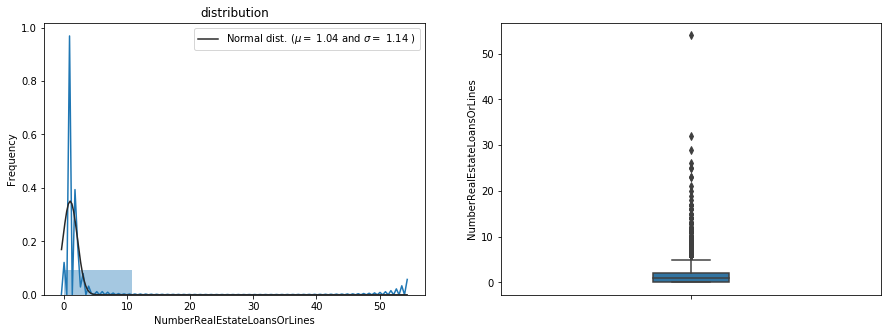

In [29]:
#输入目标变量
target = train_data.NumberRealEstateLoansOrLines

#变量分布特征
Distribution_worker(target,5)


 mu = 1.02 and sigma = 1.02



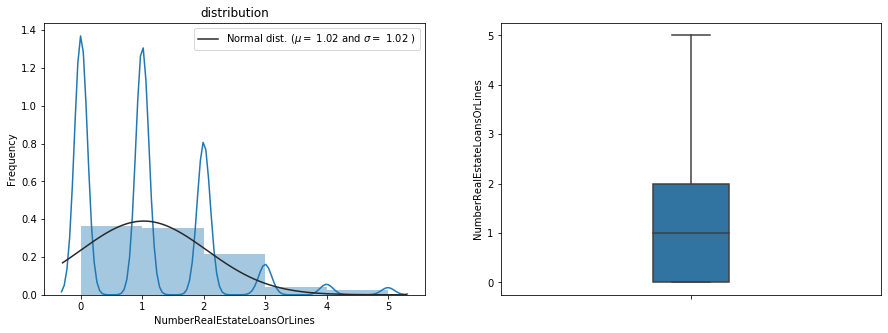

In [30]:
#天花板法处理异常值
train_data = IQR_Cleaner(train_data, 'NumberRealEstateLoansOrLines', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = train_data.NumberRealEstateLoansOrLines

#变量分布特征
Distribution_worker(target,5)

In [31]:
train_data.NumberRealEstateLoansOrLines.describe()

count    114240.000000
mean          1.023372
std           1.023193
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [32]:
train_data.NumberRealEstateLoansOrLines.unique()   #离散变量

array([5., 0., 1., 3., 4., 2.])

#### NumberOfDependents 字段---借款人的家属数量


 mu = 0.75 and sigma = 1.11



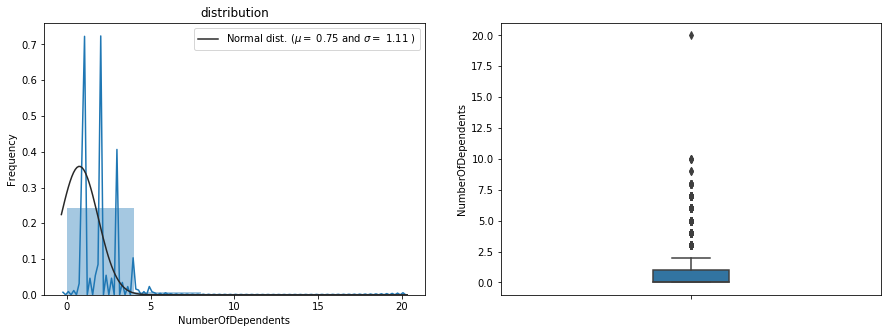

In [33]:
#输入目标变量
target = train_data.NumberOfDependents

#变量分布特征
Distribution_worker(target,5)


 mu = 0.67 and sigma = 0.91



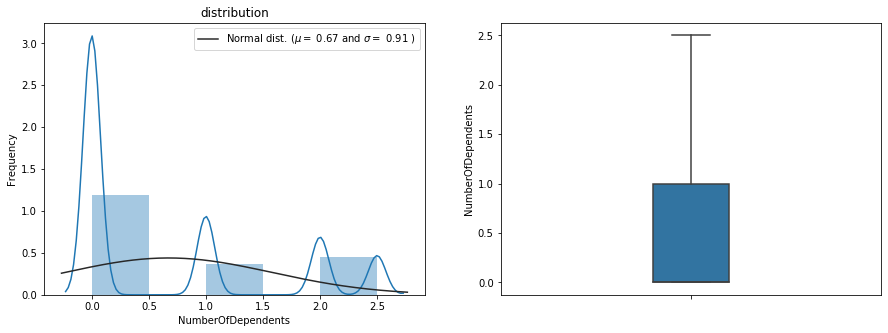

In [34]:
#天花板法处理异常值
train_data = IQR_Cleaner(train_data, 'NumberOfDependents', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = train_data.NumberOfDependents

#变量分布特征
Distribution_worker(target,5)

In [35]:
train_data.NumberOfDependents.describe()

count    114240.000000
mean          0.672479
std           0.908125
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           2.500000
Name: NumberOfDependents, dtype: float64

In [36]:
train_data.NumberOfDependents.unique()   #离散变量

array([2. , 1. , 0. , 2.5])

#### NumberOfTime30-59DaysPastDueNotWorse、NumberOfTime60-89DaysPastDueNotWorse、NumberOfTimes90DaysLate 字段---逾期次数

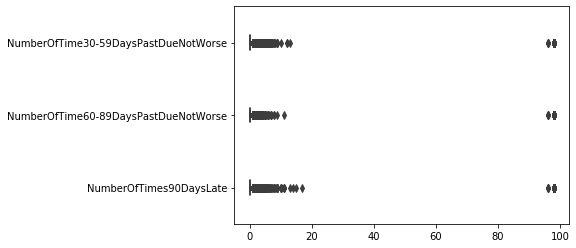

In [37]:
##观察历史信用记录数据分布情况
target = train_data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]
sns.boxplot(data =target, width=0.2,orient='h')

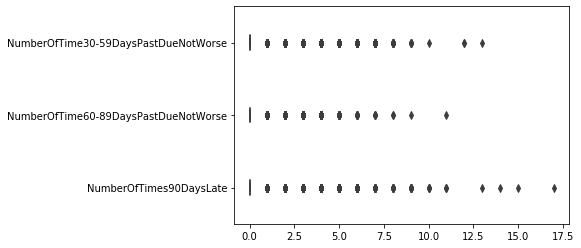

In [38]:
#观察箱形图，存在两个大于90的异常值，删除一个变量的异常值，另外两个也会跟着一起删除
train_data=train_data[train_data['NumberOfTime30-59DaysPastDueNotWorse']<90]
target = train_data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]
sns.boxplot(data =target, width=0.2,orient='h')

In [39]:
print(train_data['NumberOfTime30-59DaysPastDueNotWorse'].unique())
print(train_data['NumberOfTime60-89DaysPastDueNotWorse'].unique())
print(train_data['NumberOfTimes90DaysLate'].unique())

[ 2  0  1  3  4 10  5  6  7 12  8  9 13]
[ 0  1  2  5  3  4  6  8  7 11  9]
[ 0  1  3  2  5  4 10  9  6  8  7 15 11 13 14 17]


#### MonthlyIncome 字段---连续变量


 mu = 6094.01 and sigma = 13070.42



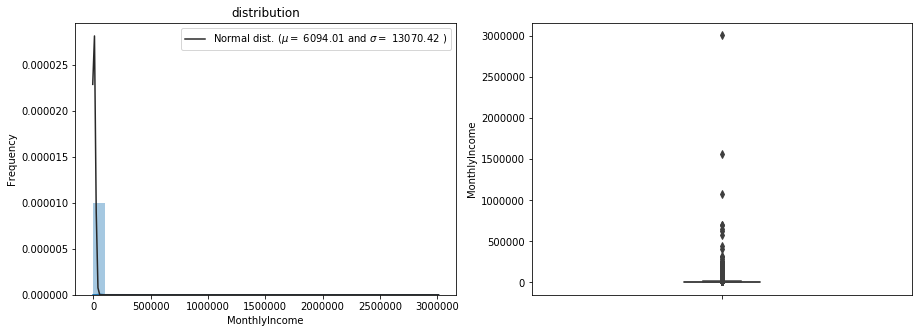

In [40]:
#输入目标变量
target = train_data.dropna().MonthlyIncome

#变量分布特征
Distribution_worker(target,30)


 mu = 5707.03 and sigma = 3891.90



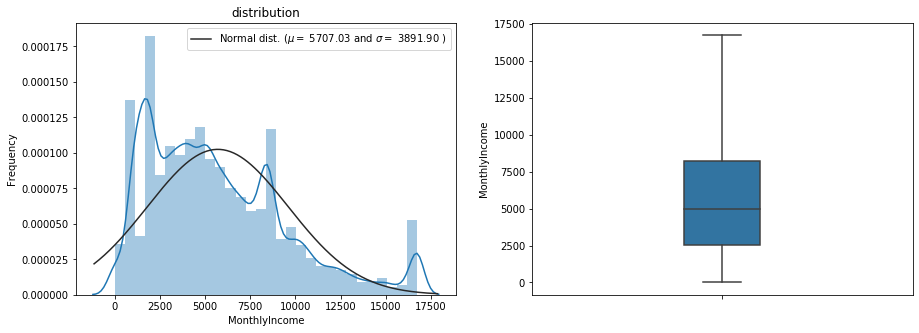

In [41]:
#天花板法处理异常值
train_data = IQR_Cleaner(train_data, 'MonthlyIncome', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = train_data.dropna().MonthlyIncome

#变量分布特征
Distribution_worker(target,30)

In [42]:
train_data.dropna().MonthlyIncome.describe()

count    114055.000000
mean       5707.030146
std        3891.917978
min           0.000000
25%        2532.500000
50%        5000.000000
75%        8210.000000
max       16726.250000
Name: MonthlyIncome, dtype: float64

## 数据建模

### 变量选择

#### 分箱处理

变量分箱(binning)是对连续变量离散化(discretization)的一种称呼。信用评分卡开发中一般有常用的等距分段、等深分段、最优分段。
其中等距分段(Equval length intervals)是指分段的区间是一致的，比如年龄以十年作为一个分段；
等深分段(Equal frequency intervals)是先确定分段数量，然后令每个分段中数据数量大致相等；
最优分段(Optimal Binning)又叫监督离散化(supervised discretizaion)，使用递归划分(Recursive Partitioning)将连续变量分为分段，背后是一种基于条件推断查找较佳分组的算法。
我们首先选择对连续变量进行最优分段，在连续变量的分布不满足最优分段的要求时，再考虑对连续变量进行等距分段。最优分箱的代码如下：

WOE分析， 是对指标分箱、计算各个档位的WOE值并观察WOE值随指标变化的趋势。其中WOE的数学定义是:
woe=ln(goodattribute/badattribute)

In [93]:
#分箱
#连续性变量--- 定义自动分箱函数---最优分箱
def mono_bin(Y, X, n=10):# X为待分箱的变量，Y为target变量,n为分箱数量
    r = 0    #设定斯皮尔曼 初始值
    badnum=Y.sum()    #计算坏样本数
    goodnum=Y.count()-badnum    #计算好样本数
    #下面这段就是分箱的核心 ，就是机器来选择指定最优的分箱节点，代替我们自己来设置
    while np.abs(r) < 1:  
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n,duplicates="drop")})#用pd.qcut实现最优分箱，Bucket：将X分为n段，n由斯皮尔曼系数决定    
        d2 = d1.groupby('Bucket', as_index = True)# 按照分箱结果进行分组聚合        
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)# 以斯皮尔曼系数作为分箱终止条件,完全单调相关
        n = n - 1    
    d3 = pd.DataFrame(d2.X.min(), columns = ['min']) 
    d3['min']=d2.min().X    #箱体的左边界
    d3['max'] = d2.max().X    #箱体的右边界
    d3['bad'] = d2.sum().Y    #每个箱体中坏样本的数量
    d3['total'] = d2.count().Y    #每个箱体的总样本数
    d3['rate'] = d2.mean().Y
    d3['badattr'] = d3['bad']/badnum  #每个箱体中坏样本所占坏样本总数的比例
    d3['goodattr'] = (d3['total'] - d3['bad'])/goodnum  # 每个箱体中好样本所占好样本总数的比例
    d3['woe']=np.log(d3['badattr']/d3['goodattr'])# 计算每个箱体的woe值=log(响应样本比例/非响应样本比例)
    d3['iv']=(d3['badattr']-d3['goodattr'])*d3['woe']  #iv值=（响应用户比例-非响应用户比例）*woe
    iv = ((d3['badattr']-d3['goodattr'])*d3['woe']).sum()  # 计算变量的iv值
    d4 = (d3.sort_index(by = 'min')).reset_index(drop=True)   # 对箱体从大到小进行排序
    print('分箱结果：')
    print(d4)
    print('IV值为：')
    print(iv)
    woe=list(d4['woe'].round(3))    
    cut=[]    #  cut 存放箱段节点
    cut.append(float('-inf'))    # 在列表前加-inf
    for i in range(1,n+1):        # n是前面的分箱的分割数，所以分成n+1份
        qua=X.quantile(i/(n+1))         #quantile 分为数  得到分箱的节点
        cut.append(round(qua,4))    # 保留4位小数       #返回cut
    cut.append(float('inf'))    # 在列表后加  inf
    print('cut箱段节点：')
    print(cut)
    return d4,iv,cut,woe

In [94]:
# #查看一个分箱过程
# Y=train_data['SeriousDlqin2yrs']
# X=train_data.RevolvingUtilizationOfUnsecuredLines
# badnum=Y.sum()    #计算坏样本数
# goodnum=Y.count()-badnum    #计算好样本数
# d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, 10,duplicates="drop")})#用pd.qcut实现最优分箱，Bucket：将X分为n段，n由斯皮尔曼系数决定    
# d2 = d1.groupby('Bucket', as_index = True)# 按照分箱结果进行分组聚合        
# r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)# 以斯皮尔曼系数作为分箱终止条件,完全单调相关
# d3 = pd.DataFrame(d2.X.min(), columns = ['min']) 
# d3['min']=d2.min().X    #箱体的左边界
# d3['max'] = d2.max().X    #箱体的右边界
# d3['bad'] = d2.sum().Y    #每个箱体中坏样本的数量
# d3['total'] = d2.count().Y    #每个箱体的总样本数
# d3['rate'] = d2.mean().Y
# d3['badattr'] = d3['bad']/badnum  #每个箱体中坏样本所占坏样本总数的比例
# d3['goodattr'] = (d3['total'] - d3['bad'])/goodnum  # 每个箱体中好样本所占好样本总数的比例
# d3['woe']=np.log(d3['badattr']/d3['goodattr'])# 计算每个箱体的woe值=log(响应样本比例/非响应样本比例)
# d3['iv']=(d3['badattr']-d3['goodattr'])*d3['woe']  #iv值=（响应用户比例-非响应用户比例）*woe
# iv = ((d3['badattr']-d3['goodattr'])*d3['woe']).sum()  # 计算变量的iv值
# d4 = (d3.sort_index(by = 'min')).reset_index(drop=True)   # 对箱体从大到小进行排序
# d4

In [96]:
x1_d,x1_iv,x1_cut,x1_woe = mono_bin(train_data['SeriousDlqin2yrs'],train_data.RevolvingUtilizationOfUnsecuredLines,n=10)

分箱结果：
        min           max   bad  total      rate   badattr  goodattr  \
0  0.000000      0.030047   571  30000  0.019033  0.071536  0.262717   
1  0.030049      0.155668   583  30000  0.019433  0.073039  0.262610   
2  0.155673      0.560433  1495  30000  0.049833  0.187296  0.254468   
3  0.560435  50708.000000  5333  30000  0.177767  0.668128  0.220206   

        woe        iv  
0 -1.300876  0.248702  
1 -1.279670  0.242587  
2 -0.306483  0.020587  
3  1.109918  0.497157  
IV值为：
1.0090342537077563
cut箱段节点：
[-inf, 0.03, 0.1557, 0.5604, inf]


In [97]:
x2_d,x2_iv,x2_cut,x2_woe = mono_bin(train_data['SeriousDlqin2yrs'],train_data.age) 

分箱结果：
   min  max   bad  total      rate   badattr  goodattr       woe        iv
0    0   33  1554  13686  0.113547  0.194688  0.108304  0.586456  0.050660
1   34   40  1333  14434  0.092351  0.167001  0.116954  0.356214  0.017827
2   41   45  1098  12950  0.084788  0.137560  0.105804  0.262464  0.008335
3   46   50  1220  15068  0.080966  0.152844  0.123623  0.212181  0.006200
4   51   54   834  11631  0.071705  0.104485  0.096386  0.080680  0.000653
5   55   59   740  13675  0.054113  0.092709  0.115473 -0.219571  0.004998
6   60   64   576  13657  0.042176  0.072162  0.116776 -0.481338  0.021474
7   65   71   332  12154  0.027316  0.041594  0.105537 -0.931112  0.059538
8   72  109   295  12745  0.023146  0.036958  0.111143 -1.101030  0.081680
IV值为：
0.2513659201114954
cut箱段节点：
[-inf, 33.0, 40.0, 45.0, 50.0, 54.0, 59.0, 64.0, 71.0, inf]


In [98]:
x4_d,x4_iv,x4_cut,x4_woe = mono_bin(train_data['SeriousDlqin2yrs'],train_data.DebtRatio) 

分箱结果：
        min            max   bad  total     rate   badattr  goodattr  \
0  0.000000       0.238242  2420  40000  0.06050  0.303182  0.335482   
1  0.238244       0.569850  2508  40000  0.06270  0.314207  0.334696   
2  0.569852  329664.000000  3054  40000  0.07635  0.382611  0.329822   

        woe        iv  
0 -0.101234  0.003270  
1 -0.063171  0.001294  
2  0.148465  0.007837  
IV值为：
0.012401473538035614
cut箱段节点：
[-inf, 0.2382, 0.5699, inf]


In [99]:
x5_d,x5_iv,x5_cut,x5_woe = mono_bin(train_data['SeriousDlqin2yrs'],train_data.MonthlyIncome)

分箱结果：
      min        max   bad  total      rate   badattr  goodattr       woe  \
0     0.0     3400.0  2214  24229  0.091378  0.277374  0.196531  0.344547   
1  3401.0     5400.0  1884  24090  0.078207  0.236031  0.198236  0.174505   
2  5401.0     8250.0  1442  23902  0.060330  0.180656  0.200503 -0.104234   
3  8251.0  3008750.0  1100  24003  0.045828  0.137810  0.204458 -0.394487   

         iv  
0  0.027854  
1  0.006595  
2  0.002069  
3  0.026292  
IV值为：
0.06281031637221683
cut箱段节点：
[-inf, 3400.0, 5400.0, 8250.0, inf]


In [100]:
#离散型变量-手动分箱
def self_bin(Y,X,cut):    
    badnum=Y.sum()    # 坏用户数量
    goodnum=Y.count()-badnum    #好用户数量
    d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.cut(X, cut)})#建立个数据框 X-- 各个特征变量 ， Y--用户好坏标签 ， Bucket--各个分箱    
    d2 = d1.groupby('Bucket', as_index = True)# 按照分箱结果进行分组聚合
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])    #  添加 min 列 ,不用管里面的 d2.X.min()
    d3['min']=d2.min().X    
    d3['max'] = d2.max().X    
    d3['bad'] = d2.sum().Y    
    d3['total'] = d2.count().Y    
    d3['rate'] = d2.mean().Y
    d3['badattr'] = d3['bad']/badnum  #每个箱体中坏样本所占坏样本总数的比例
    d3['goodattr'] = (d3['total'] - d3['bad'])/goodnum  # 每个箱体中好样本所占好样本总数的比例
    d3['woe']=np.log(d3['badattr']/d3['goodattr'])# 计算每个箱体的woe值=log(响应样本比例/非响应样本比例)
    d3['iv']=(d3['badattr']-d3['goodattr'])*d3['woe']  #iv值=（响应用户比例-非响应用户比例）*woe
    iv = ((d3['badattr']-d3['goodattr'])*d3['woe']).sum()  # 计算变量的iv值  # 计算变量的iv值
    d4 = (d3.sort_index(by = 'min')).reset_index(drop=True)   # 对箱体从大到小进行排序
    woe=list(d4['woe'].round(3))
    return d4,iv,woe

In [101]:
#观察离散字段的分档
#数据区间
def a_range(a_rate):
    rate_0 = np.percentile(a_rate, 0)
    rate_10 = np.percentile(a_rate, 10)
    rate_20 = np.percentile(a_rate, 20)
    rate_30 = np.percentile(a_rate, 30)
    rate_40 = np.percentile(a_rate, 40)
    rate_50 = np.percentile(a_rate, 50)
    rate_60 = np.percentile(a_rate, 60)
    rate_70 = np.percentile(a_rate, 70)
    rate_80 = np.percentile(a_rate, 80)
    rate_90 = np.percentile(a_rate, 90)
    rate_100 = np.percentile(a_rate, 100)
    rate_name=['rate_0','rate_10','rate_20','rate_30','rate_40','rate_50','rate_60','rate_70','rate_80','rate_90','rate_100']
    rate_value=[rate_0,rate_10,rate_20,rate_30,rate_40,rate_50,rate_60,rate_70,rate_80,rate_90,rate_100]
    range_rate=pd.DataFrame({"range":rate_name,"range_value":rate_value})
    return range_rate

In [102]:
a_range(train_data["NumberOfTime30-59DaysPastDueNotWorse"].dropna().values)

,range,range_value
0,rate_0,0.0
1,rate_10,0.0
2,rate_20,0.0
3,rate_30,0.0
4,rate_40,0.0
5,rate_50,0.0
6,rate_60,0.0
7,rate_70,0.0
8,rate_80,0.0
9,rate_90,1.0


In [103]:
ninf = float('-inf')#负无穷大
pinf = float('inf')#正无穷大
cutx3 = [ninf, 0, 1, pinf]
dfx3,ivx3,woex3 = self_bin(train_data.SeriousDlqin2yrs,train_data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3)
dfx3

,min,max,bad,total,rate,badattr,goodattr,woe,iv
0,0,0,4041,100829,0.040078,0.506264,0.864040,-0.534560,0.191253
1,1,1,1910,12856,0.148569,0.239288,0.097716,0.895600,0.126792
2,2,98,2031,6315,0.321615,0.254448,0.038244,1.895112,0.409730


In [104]:
ivx3

0.7277745072220502

In [105]:
a_range(train_data["NumberOfOpenCreditLinesAndLoans"].dropna().values)

,range,range_value
0,rate_0,0.0
1,rate_10,3.0
2,rate_20,4.0
3,rate_30,5.0
4,rate_40,6.0
5,rate_50,8.0
6,rate_60,9.0
7,rate_70,10.0
8,rate_80,12.0
9,rate_90,15.0


In [106]:
cutx6 = [ninf, 4, 7, 9,12,pinf]
dfx6,ivx6 ,woex6= self_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfOpenCreditLinesAndLoans'], cutx6)
dfx6

,min,max,bad,total,rate,badattr,goodattr,woe,iv
0,0,4,2468,26967,0.091519,0.309196,0.218706,0.346246,0.031332
1,5,7,1840,31783,0.057893,0.230519,0.267305,-0.148059,0.005447
2,8,9,1006,19066,0.052764,0.126034,0.161224,-0.246247,0.008666
3,10,12,1200,19964,0.060108,0.150338,0.167509,-0.108148,0.001857
4,13,58,1468,22220,0.066067,0.183914,0.185256,-0.007271,0.000010


In [107]:
ivx6

0.047310628342876866

In [108]:
a_range(train_data["NumberOfTimes90DaysLate"].dropna().values)

,range,range_value
0,rate_0,0.0
1,rate_10,0.0
2,rate_20,0.0
3,rate_30,0.0
4,rate_40,0.0
5,rate_50,0.0
6,rate_60,0.0
7,rate_70,0.0
8,rate_80,0.0
9,rate_90,0.0


In [109]:
cutx7 = [ninf, 0,1, pinf]
dfx7,ivx7,woex7 = self_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfTimes90DaysLate'], cutx7)
dfx7

,min,max,bad,total,rate,badattr,goodattr,woe,iv
0,0,0,5223,113277,0.046108,0.654347,0.964613,-0.388089,0.120411
1,1,1,1408,4236,0.332389,0.176397,0.025246,1.944071,0.293848
2,2,98,1351,2487,0.543225,0.169256,0.010141,2.814802,0.447876


In [110]:
ivx7

0.8621348470397092

In [111]:
a_range(train_data["NumberRealEstateLoansOrLines"].dropna().values)

,range,range_value
0,rate_0,0.0
1,rate_10,0.0
2,rate_20,0.0
3,rate_30,0.0
4,rate_40,1.0
5,rate_50,1.0
6,rate_60,1.0
7,rate_70,1.0
8,rate_80,2.0
9,rate_90,2.0


In [112]:
cutx8 = [ninf, 0,1,2, 3, pinf]
dfx8, ivx8,woex8 = self_bin(train_data.SeriousDlqin2yrs, train_data['NumberRealEstateLoansOrLines'], cutx8)
dfx8

,min,max,bad,total,rate,badattr,goodattr,woe,iv
0,0,0,3745,44875,0.083454,0.469181,0.367173,0.245154,0.025008
1,1,1,2180,41848,0.052093,0.273115,0.354122,-0.259749,0.021042
2,2,2,1389,25303,0.054895,0.174017,0.213484,-0.204409,0.008067
3,3,3,331,5041,0.065662,0.041468,0.042047,-0.013854,0.000008
4,4,54,337,2933,0.114899,0.042220,0.023175,0.599826,0.011424


In [113]:
ivx8

0.0655483771101574

In [114]:
a_range(train_data["NumberOfTime60-89DaysPastDueNotWorse"].dropna().values)

,range,range_value
0,rate_0,0.0
1,rate_10,0.0
2,rate_20,0.0
3,rate_30,0.0
4,rate_40,0.0
5,rate_50,0.0
6,rate_60,0.0
7,rate_70,0.0
8,rate_80,0.0
9,rate_90,0.0


In [115]:
cutx9 = [ninf, 0, 1, pinf]
dfx9, ivx9,woex9 = self_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfTime60-89DaysPastDueNotWorse'], cutx9)
dfx9

,min,max,bad,total,rate,badattr,goodattr,woe,iv
0,0,0,5803,113965,0.050919,0.727011,0.965577,-0.283785,0.067701
1,1,1,1411,4564,0.309159,0.176773,0.028147,1.837415,0.273087
2,2,98,768,1471,0.522094,0.096216,0.006276,2.729903,0.245529


In [116]:
ivx9

0.5863174985660469

In [117]:
a_range(train_data["NumberOfDependents"].dropna().values)

,range,range_value
0,rate_0,0.0
1,rate_10,0.0
2,rate_20,0.0
3,rate_30,0.0
4,rate_40,0.0
5,rate_50,0.0
6,rate_60,1.0
7,rate_70,1.0
8,rate_80,2.0
9,rate_90,2.0


In [118]:
cutx10 = [ninf, 0, 1, 2, pinf]
dfx10,ivx10,woex10 = self_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfDependents'], cutx10)
dfx10

,min,max,bad,total,rate,badattr,goodattr,woe,iv
0,0.0,0.0,4074,69464,0.058649,0.510398,0.583745,-0.134273,0.009849
1,1.0,1.0,1535,21158,0.072549,0.192308,0.175177,0.093299,0.001598
2,2.0,2.0,1267,15630,0.081062,0.158732,0.128220,0.213467,0.006513
3,3.0,20.0,961,10608,0.090592,0.120396,0.086120,0.335043,0.011484


In [119]:
ivx10

0.02944391135334792

#### 相关性分析

接下来，我们会用经过清洗后的数据看一下变量间的相关性。
注意，这里的相关性分析只是初步的检查，进一步检查模型的 VI （证据权重）作为变量筛选的依据。
相关性图我们通过Python里面的seaborn包，调用heatmap()绘图函数进行绘制，实现代码如下：

age


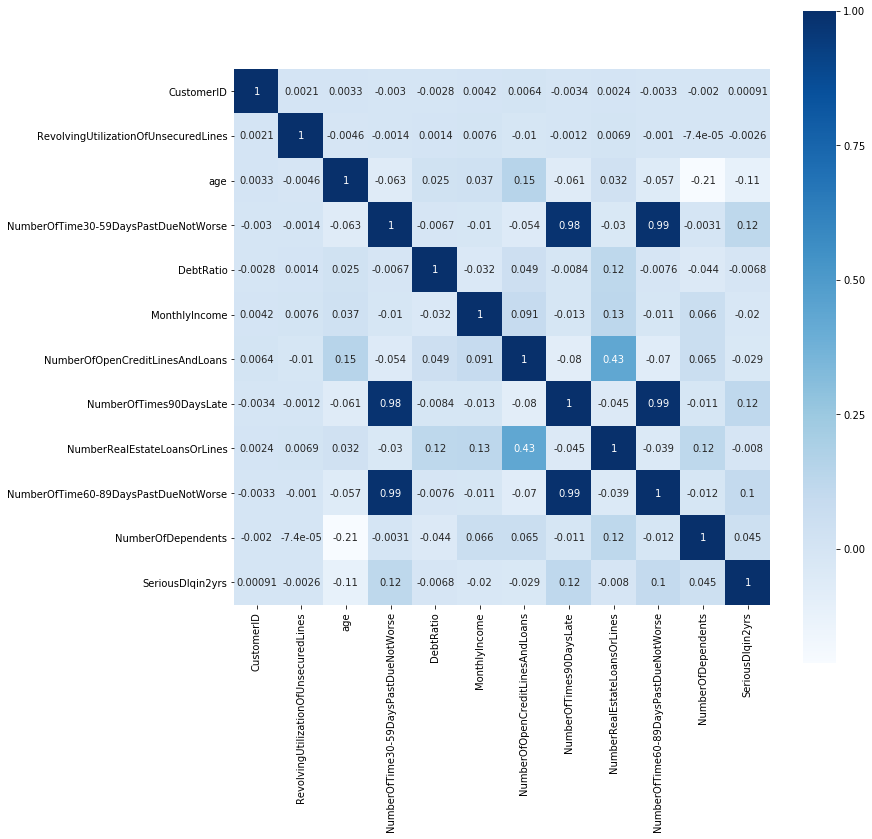

In [120]:
corr = train_data.corr()#计算各变量的相关性系数
print(max(corr))
plt.subplots(figsize=(12, 12))
sns.heatmap(corr, annot=True, vmax=1, square=True, cmap='Blues')

相关性表没有查看出特别相关的变量，相关性分析只是初步的检查，进一步检查模型的VI（证据权重）作为变量筛选的依据。

#### IV筛选

接下来，进一步计算每个变量的 Infomation Value(IV) 。IV 指标是一般用来确定自变量的预测能力。 其公式为：
IV=sum((goodattribute-badattribute)*ln(goodattribute/badattribute))
通过IV值判断变量预测能力的标准是：
< 0.02: unpredictive
0.02 to 0.1: weak
0.1 to 0.3: medium
0.3 to 0.5: strong
> 0.5: suspicious   (标准）

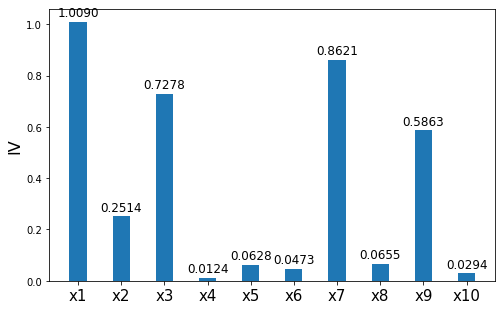

In [121]:
#IV值筛选
#通过IV值判断变量预测能力的标准是:小于 0.02: unpredictive；0.02 to 0.1: weak；0.1 to 0.3: medium； 0.3 to 0.5: strong
ivlist=[x1_iv,x2_iv,ivx3,x4_iv,x5_iv,ivx6,ivx7,ivx8,ivx9,ivx10]#各变量IV
index=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']#x轴的标签
fig1 = plt.figure(1,figsize=(8,5))
ax1 = fig1.add_subplot(1, 1, 1)
x = np.arange(len(index))+1 
ax1.bar(x,ivlist,width=.4) #  ax1.bar(range(len(index)),ivlist, width=0.4)#生成柱状图  #ax1.bar(x,ivlist,width=.04)
ax1.set_xticks(x)
ax1.set_xticklabels(index, rotation=0, fontsize=15)
ax1.set_ylabel('IV', fontsize=16)   #IV(Information Value),
#在柱状图上添加数字标签
for a, b in zip(x, ivlist):
    plt.text(a, b + 0.01, '%.4f' % b, ha='center', va='bottom', fontsize=12)
plt.show()

iv值小于0.1的特征可以删除，则删除DebtRatio (x4)-负债比率、NumberOfDependents(x10)-借款人的家属数量（不包括本人在内）、MonthlyIncome(x5)-月收入，NumberOfOpenCreditLinesAndLoans(x6)-开放贷款数量，NumberRealEstateLoansOrLines(x8)-房地产贷款数量

重要的特征是RevolvingUtilizationOfUnsecuredLines（x1）-信用贷款比例，NumberOfTimes90DaysLate（x7）-两年内90天或高于90天逾期的次数，NumberOfTime30-59DaysPastDueNotWorse（x3）-两年内35-59天逾期次数，NumberOfTime60-89DaysPastDueNotWorse（x9）-两年内60-89天逾期次数，age（x2）-年龄

### 建立逻辑回归模型

#### 训练集建模

证据权重（Weight of Evidence,WOE）转换可以将Logistic回归模型转变为标准评分卡格式。引入WOE转换的目的并不是为了提高模型质量，只是一些变量不应该被纳入模型，或者是因为它们不能增加模型值，再或者是因为与其模型相关系数有关的误差较大，其实建立标准信用评分卡也可以不采用WOE转换。
这种情况下，Logistic回归模型需要处理更大数量的自变量。尽管这样会增加建模程序的复杂性，但最终得到的评分卡都是一样的。
在建立模型之前，我们需要将筛选后的变量转换为WOE值，便于信用评分。

In [122]:
#进行WOE编码,按照分档，把各分档值赋成对应woe
def trans_woe(var,var_name,woe,cut):
    woe_name=var_name+'_woe'
    for i in range(len(woe)):       # len(woe) 得到woe里 有多少个数值
        if i==0:
            var.loc[(var[var_name]<=cut[i+1]),woe_name]=woe[i]  #将woe的值按 cut分箱的下节点，顺序赋值给var的woe_name 列 ，分箱的第一段
        elif (i>0) and  (i<=len(woe)-2):
            var.loc[((var[var_name]>cut[i])&(var[var_name]<=cut[i+1])),woe_name]=woe[i] #    中间的分箱区间
        else:
            var.loc[(var[var_name]>cut[len(woe)-1]),woe_name]=woe[len(woe)-1]   # 大于最后一个分箱区间的 上限值，最后一个值是正无穷
    return var

In [123]:
x1_name='RevolvingUtilizationOfUnsecuredLines'
x2_name='age'
x3_name='NumberOfTime30-59DaysPastDueNotWorse'
x7_name='NumberOfTimes90DaysLate'
x9_name='NumberOfTime60-89DaysPastDueNotWorse'

train_data=trans_woe(train_data,x1_name,x1_woe,x1_cut)
train_data=trans_woe(train_data,x2_name,x2_woe,x2_cut)
train_data=trans_woe(train_data,x3_name,woex3,cutx3)
train_data=trans_woe(train_data,x7_name,woex7,cutx7)
train_data=trans_woe(train_data,x9_name,woex9,cutx9)

Y=train_data['SeriousDlqin2yrs']   #因变量
#自变量，剔除对因变量影响不明显的变量
X=train_data.drop(['SeriousDlqin2yrs','DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)
X=train_data.iloc[:,-5:]
X.head()

,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe
0,1.110,0.262,1.895,-0.388,-0.284
1,1.110,0.356,-0.535,-0.388,-0.284
2,1.110,0.356,0.896,1.944,-0.284
3,-0.306,0.586,-0.535,-0.388,-0.284
4,1.110,0.212,0.896,-0.388,-0.284


In [124]:
# STATSMODEL包来建立逻辑回归模型得到回归系数，后面可用于建立标准评分卡
import statsmodels.api as sm
X1=sm.add_constant(X)
logit=sm.Logit(Y,X1)
result=logit.fit()
print(result)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.185492
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               120000
Model:                          Logit   Df Residuals:                   119994
Method:                           MLE   Df Model:                            5
Date:                Sun, 15 Mar 2020   Pseudo R-squ.:                  0.2414
Time:                        11:15:54   Log-Likelihood:                -22259.
converged:                       True   LL-Null:                       -29344.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6

#### 模型检验

到这里，我们的建模部分基本结束了。我们需要验证一下模型的预测能力如何。我们使用在建模开始阶段预留的 test 数据进行检验。通过 ROC 曲线和 AUC 来评估模型的拟合能力。
在 Python 中，可以利用 sklearn.metrics，它能方便比较两个分类器，自动计算 ROC 和 AUC 。

In [125]:
#对训练集模型做模拟和评估
import statsmodels.api as sm
train_data=trans_woe(train_data,x1_name,x1_woe,x1_cut)
train_data=trans_woe(train_data,x2_name,x2_woe,x2_cut)
train_data=trans_woe(train_data,x3_name,woex3,cutx3)
train_data=trans_woe(train_data,x7_name,woex7,cutx7)
train_data=trans_woe(train_data,x9_name,woex9,cutx9)
#print(train_data)
#构建测试集的特征和标签
test_X=train_data.iloc[:,-5:]   #测试数据 特征
#print(test_X)
test_Y=train_data['SeriousDlqin2yrs'] #测试数据  标签
#print(test_Y)
#print(test_Y.dtype)
#print(test_Y.count())


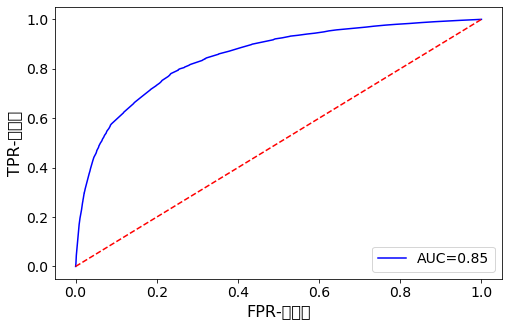

In [126]:
#评估
from sklearn import metrics
X3=sm.add_constant(test_X)
resu = result.predict(X3)    #进行预测
fpr,tpr,threshold=metrics.roc_curve(test_Y,resu)   #评估算法
rocauc=metrics.auc(fpr,tpr)   #计算AUC

plt.figure(figsize=(8,5))  #只能在这里面设置
plt.plot(fpr,tpr,'b',label='AUC=%0.2f'% rocauc)
plt.legend(loc='lower right',fontsize=14)
plt.plot([0.0, 1.0], [0.0, 1.0], 'r--')
plt.xlim=([0.0, 1.0])
plt.ylim=([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('TPR-真正率',fontsize=16)
plt.xlabel('FPR-假正率',fontsize=16)
plt.show()

AUC低于0.5，区分度弱于随机猜测，0.5-0.6有较弱的区分度，0.6-0.7，有一定的区分度，>0.7有很强的区分度。
从上图可知，AUC 值为 0.84，说明该模型的预测效果还是不错的，正确率较高。

## 信用评分

那么如何将概率值转化为评分呢，其实怎么算都可以，这里采用评分卡转换的方式，具体网上都有详细解释，这里简要讲下，违约与正常比率被定义为一个记录被划分为违约的估计概率与被划分为正常的估计概率之间的比率，将估计违约概率用p表示，估计正常概率为1-p。因此可定义发生比：
Odds=p/(1-p)

score=Odds*factor+offset

上式中，factor 和offset 为待指定的参数。根据评分卡不同的需要可以调节factor 和offset从而得到理想的分数范围。比如，如果我们需要优势比为20的时候，其对应的分数为600？；并且每当优势比变为之前的2倍时候，其对应的分数增加20。基于上面两个限制，我们可以得到两个方程：

1\600=ln(20)*factor+offset
2\600+20=ln(20*2)*factor+offset


factor=20/ln(2)
offset=600-factor*ln(50)

对于logistic回归算法，odds也可以表示为：

log(Odds)=B0+B1*X1+B2*X2+…+BnXn

由此可得：

Score=offset+factor*（B0+B1*X1+B2*X2+…+BnXn）

在建立标准评分卡之前，还需要设定几个评分卡参数：基础分值、 PDO（比率翻倍的分值）和好坏比。 这里， 我们取600分为基础分值b，取20为PDO （每高20分好坏比翻一倍），好坏比O取20。

### 在测试集创建信用评分卡

In [127]:
p=20/np.log(2)#比例因子
q=600-20*np.log(20)/np.log(2)#等于offset,偏移量
x_coe=[-2.7340,0.6526,0.5201,0.5581,0.5943,0.4329]#回归系数  ???
baseScore=round(q+p*x_coe[0],0)

#个人总评分=基础分+各部分得分
def get_score(coe,woe,factor):
    scores=[]
    for w in woe:
        score=round(coe*w*factor,0)
        scores.append(score)
    return scores
#每一项得分
x1_score=get_score(x_coe[1],x1_woe,p)
x2_score=get_score(x_coe[2],x2_woe,p)
x3_score=get_score(x_coe[3],woex3,p)
x7_score=get_score(x_coe[4],woex7,p)
x9_score=get_score(x_coe[5],woex9,p)

def compute_score(series,cut,score):
    list = []
    i = 0
    while i < len(series):
        #print(series[i].dtype)
        #print(series.iloc[i])
        value = series.iloc[i]
        j = len(cut) - 2
        m = len(cut) - 2
        while j >= 0:
            if value >= cut[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list.append(score[m])
        i += 1
    return list

In [128]:
train_data['BaseScore']=np.zeros(len(train_data))+baseScore
train_data['x1'] =compute_score(train_data['RevolvingUtilizationOfUnsecuredLines'], x1_cut, x1_score)
train_data['x2'] = compute_score(train_data['age'], x2_cut, x2_score)
train_data['x3'] = compute_score(train_data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, x3_score)
train_data['x7'] = compute_score(train_data['NumberOfTimes90DaysLate'], cutx7, x7_score)
train_data['x9'] = compute_score(train_data['NumberOfTime60-89DaysPastDueNotWorse'],cutx9,x9_score)
train_data['Score'] = train_data['x1'] + train_data['x2'] + train_data['x3'] + train_data['x7'] +train_data['x9']  + baseScore

scoretable1=train_data.iloc[:,[0,-7,-6,-5,-4,-3,-2,-1]]  #选取需要的列，就是评分列
scoretable1.head()

colNameDict={'x1': 'RevolvingUtilizationOfUnsecuredLines' ,'x2':'age','x3':'NumberOfTime30-59DaysPastDueNotWorse',
             'x7':'NumberOfTimes90DaysLate', 'x9':'NumberOfTime60-89DaysPastDueNotWorse'}
scoretable1=scoretable1.rename(columns=colNameDict,inplace=False)
scoretable1.to_excel(r'训练集评分卡.xlsx')

### 对测试集进行预测和转化为信用评分卡

In [129]:
#Logistic回归模型——将训练集的数据分为测试集和训练集
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#自变量，剔除对因变量影响不明显的变量
train_data=train_data.drop(['DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)

training,testing=train_test_split(train_data,test_size=0.25,random_state=1)
#Y=train_data['SeriousDlqin2yrs']   #因变量
#X=train_data.iloc[:,-5:]

#创建训练集和测试集各自的自变量和因变量
x_train=training.iloc[:,-5:]
y_train=training['SeriousDlqin2yrs']
x_test=testing.iloc[:,-5:]
y_test=testing['SeriousDlqin2yrs']
clf = LogisticRegression()
clf.fit(x_train,y_train)
#对测试集做预测
score_proba = clf.predict_proba(x_test)
y_predproba=score_proba[:,1]
coe = clf.coef_
print(coe)

[[0.00887092 0.03298466 0.07668265 0.06394643 0.02617817]]


## 模型评估

### 模型准确性评估

感受性曲线下面积(ROC_AUC)是一个从整体上评价模型准确性的指标，是感受性曲线(ROC)与横轴之间的面积。相比于其他评价指标，感受性曲线(ROC)具有一定的稳定性，它不会因为正负样本分布的变化而产生不同的曲线。感受性曲线(ROC)通过真阳率(True Positive Rate, TPR)和假阳率(False Positive Rate, FPR)两个指标进行绘制，感受性曲线(ROC)示意如图1所示，感受性曲线下面积(ROC_AUC)取值范围为[0,1],取值越大，代表模型整体准确性越好。

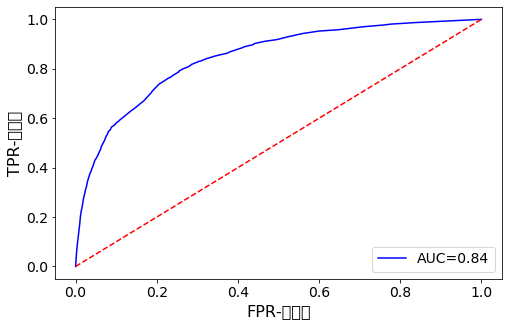

In [130]:
#对模型做评估
from sklearn.metrics import roc_curve,auc
fpr,tpr,threshold = roc_curve(y_test,y_predproba)
auc_score=auc(fpr,tpr)
plt.figure(figsize=(8,5))  #只能在这里面设置
plt.plot(fpr,tpr,'b',label='AUC=%0.2f'% auc_score)
plt.legend(loc='lower right',fontsize=14)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim=([0, 1])
plt.ylim=([0, 1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('TPR-真正率',fontsize=16)
plt.xlabel('FPR-假正率',fontsize=16)
plt.show()

### 模型区分度评估

区分度指标(KS)是度量具体模型下正常样本和违约样本分布的最大差距，金融领域评估信用模型的一个核心方法，首先按照样本的信用分数或预测违约率从小到大进行排序，然后计算每一个分数或违约率下好坏样本的累计占比，正常和违约样本的累计占比差值的最大值即为区分度指标(KS)，区分度指标(KS)的示意如图所示，区分度指标(KS)小于0.2代表模型准确性差，超过0.5则代表模型准确性高。

KS指标: 用以评估模型对好、坏客户的判别区分能力，计算累计坏客户与累计好客户百分比的最大差距。KS值范围在0%-100%，判别标准如下：

KS: <20% : 差

KS: 20%-40% : 一般

KS: 41%-50% : 好

KS: 51%-75% : 非常好

KS: >75% : 过高，需要谨慎的验证模型

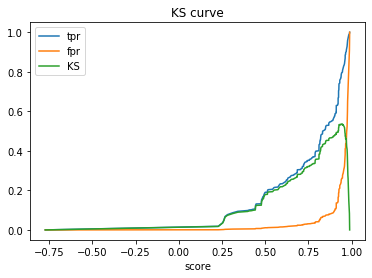

<Figure size 1440x1440 with 0 Axes>

KS 0.5360153679220494


In [131]:
KS = max(tpr-fpr)
fig,ax = plt.subplots()
ax.plot(1-threshold,tpr,label='tpr')
ax.plot(1-threshold,fpr,label='fpr')
ax.plot(1-threshold,tpr-fpr,label='KS')
plt.xlabel('score')
plt.title('KS curve')
plt.xlim=([0.0,1.0])
plt.ylim=([0.0,1.0])
plt.figure(figsize=(20,20))
legend=ax.legend(loc='upper left')
plt.show()
print("KS",KS)

#模型的AUC值达到0.84，K-S值达到0.537说明建模的效果很不错。

### 在测试集建立信用评分卡

In [132]:
#预测测试集
#测试集转化为WOE值
test_data=trans_woe(test_data,x1_name,x1_woe,x1_cut)
test_data=trans_woe(test_data,x2_name,x2_woe,x2_cut)
test_data=trans_woe(test_data,x3_name,woex3,cutx3)
test_data=trans_woe(test_data,x7_name,woex7,cutx7)
test_data=trans_woe(test_data,x9_name,woex9,cutx9)


#自变量，剔除对因变量影响不明显的变量
test_data=test_data.drop(['DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)
X_test=test_data.iloc[:,-5:]
Y_test=test_data['SeriousDlqin2yrs']   #因变量
X_train=training.copy().iloc[:,-5:]
Y_train=training.copy()['SeriousDlqin2yrs']
clf = LogisticRegression()
clf.fit(X_train,Y_train)
#对测试集做预测
score_proba = clf.predict_proba(X_test)
#print(score_proba)
test_data['y_predproba']=score_proba[:,1]
#y_predproba = score_proba[:,1]
coe = clf.coef_
print('-------------------')
print(coe)
p=20/np.log(2)#比例因子
q=600-20*np.log(20)/np.log(2)#等于offset,偏移量
x_coe=[-2.7340,0.6526,0.5201,0.5581,0.5943,0.4329]#回归系数  ???
baseScore=round(q+p*x_coe[0],0)
#个人总评分=基础分+各部分得分
def get_score(coe,woe,factor):
    scores=[]
    for w in woe:
        score=round(coe*w*factor,0)
        scores.append(score)
    return scores
#每一项得分
x1_score=get_score(x_coe[1],x1_woe,p)
x2_score=get_score(x_coe[2],x2_woe,p)
x3_score=get_score(x_coe[3],woex3,p)
x7_score=get_score(x_coe[4],woex7,p)
x9_score=get_score(x_coe[5],woex9,p)

def compute_score(series,cut,score):
    list = []
    i = 0
    while i < len(series):
        #print(series[i].dtype)
        #print(series.iloc[i])
        value = series.iloc[i]
        j = len(cut) - 2
        m = len(cut) - 2
        while j >= 0:
            if value >= cut[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list.append(score[m])
        i += 1
    return list

-------------------
[[0.00887092 0.03298466 0.07668265 0.06394643 0.02617817]]


In [133]:

test_data['BaseScore']=np.zeros(len(test_data))+baseScore
test_data['x1'] =compute_score(test_data['RevolvingUtilizationOfUnsecuredLines'], x1_cut, x1_score)
test_data['x2'] = compute_score(test_data['age'], x2_cut, x2_score)
test_data['x3'] = compute_score(test_data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, x3_score)
test_data['x7'] = compute_score(test_data['NumberOfTimes90DaysLate'], cutx7, x7_score)
test_data['x9'] = compute_score(test_data['NumberOfTime60-89DaysPastDueNotWorse'],cutx9,x9_score)
test_data['Score'] = test_data['x1'] + test_data['x2'] + test_data['x3'] + test_data['x7'] +test_data['x9']  + baseScore

scoretable2=test_data.iloc[:,[0,-8,-7,-6,-5,-4,-3,-2,-1]]  #选取需要的列，就是评分列
print(scoretable2.head())

colNameDict={'x1': 'RevolvingUtilizationOfUnsecuredLines' ,'x2':'age','x3':'NumberOfTime30-59DaysPastDueNotWorse',
             'x7':'NumberOfTimes90DaysLate', 'x9':'NumberOfTime60-89DaysPastDueNotWorse'}
scoretable2=scoretable2.rename(columns=colNameDict,inplace=False)
scoretable2.to_excel(r'测试集评分卡.xlsx')
#导出数据后再根据y_predproba<0.5的，SeriousDlqin2yrs=0，否则为1去填充

   CustomerID   y_predproba  BaseScore    x1    x2    x3    x7    x9  Score
0      120001  8.055463e-10      435.0  -6.0   3.0  14.0  33.0  23.0  502.0
1      120002  9.335137e-10      435.0  21.0  -3.0  14.0  48.0  23.0  538.0
2      120003  1.011444e-09      435.0  -6.0  -7.0  31.0  33.0  34.0  520.0
3      120004  7.646248e-10      435.0 -24.0 -17.0  14.0  33.0  23.0  464.0
4      120005  7.646248e-10      435.0 -24.0 -17.0  14.0  33.0  23.0  464.0
